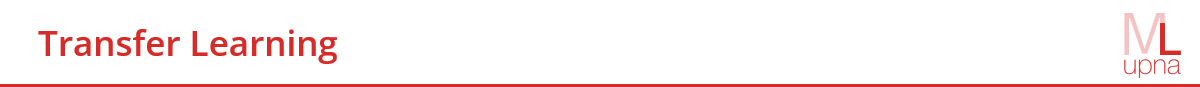

In this exercise, you will learn how to train a <span style="color:#D52B29">Convolutional Neural Network (CNN)</span> for image classification using <span style="color:#D52B29">transfer learning</span>.  

We will first train a model <span style="color:#D52B29">from scratch</span> to establish a baseline. After that, we will leverage the power of <span style="color:#D52B29">pretrained models</span> to observe how transfer learning improves performance, reduces training time, and requires less labeled data.  

In this context, we will explore both main approaches to <span style="color:#D52B29">transfer learning</span>:  

- <span style="color:#D52B29">Feature extraction</span> – freezing the early layers of the network and replacing the top layers for our specific task.  
- <span style="color:#D52B29">Fine-tuning</span> – unfreezing and retraining some or all layers of the network. In this case, we will dive into techniques such as <span style="color:#D52B29">gradual unfreezing</span> and the use of <span style="color:#D52B29">layer-wise learning rates</span>.  

## <span style="color:#D52B29">Training a model from scratch</span>

We will build on the code developed in the <span style="color:#D52B29">introduction to PyTorch Lightning</span> exercise. However, instead of using the <span style="color:#D52B29">3-layer fully connected neural network</span>, we will replace it with a <span style="color:#D52B29">Residual Network (ResNet)</span> architecture. Specifically, we will use the <span style="color:#D52B29">ResNet-18</span> model from the <span style="color:#D52B29">torchvision</span> package, which consists of <span style="color:#D52B29">18 trainable layers</span>.  


##### <span style="color:#D52B29">Model</span>

In [1]:
from torchvision import models

model = models.resnet18()

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

As we can see, the last layer of the model takes <span style="color:#D52B29">512 input features</span> and produces <span style="color:#D52B29">1000 outputs</span>:  

`(fc): Linear(in_features=512, out_features=1000, bias=True)`  

This happens because most pretrained models are designed for <span style="color:#D52B29">ImageNet</span>, a large-scale image classification dataset with <span style="color:#D52B29">1000 classes</span>.  

However, in our case we are working with <span style="color:#D52B29">CIFAR10</span>, which only has <span style="color:#D52B29">10 classes</span>. Therefore, we need to adapt the last layer of the network to match our problem. Let’s see how to modify it.

In [2]:
from torch import nn

model = models.resnet18()

# The last fully connected layer takes 512 input features in this architecture
num_in_feat = model.fc.in_features

# Replace the default classification layer (1000 outputs for ImageNet)
# with a new layer that outputs 10 classes for MNIST
model.fc = nn.Linear(num_in_feat, 10)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##### <span style="color:#D52B29">Data</span>

In [3]:
import os
import json
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import seaborn as sns

In [4]:
class CassavaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["label"])
        if self.transform:
            image = self.transform(image)
        return image, label


class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="cassava", csv_path="cassava/cassava_split.csv", json_path="cassava/label_num_to_disease_map.json", batch_size=64, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.json_path = json_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Transforms (standard ImageNet normalization)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to match common CNN input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def setup(self, stage=None):
        # Load metadata
        df = pd.read_csv(self.csv_path)
        with open(self.json_path, "r") as f:
            self.class_mapping = json.load(f)

        # Split according to 'set' column
        train_df = df[df["set"] == "train"]
        val_df = df[df["set"] == "val"]
        test_df = df[df["set"] == "test"]

        # Create datasets
        self.train_ds = CassavaDataset(train_df, os.path.join(self.data_dir, "images"), transform=self.transform)
        self.val_ds = CassavaDataset(val_df, os.path.join(self.data_dir, "images"), transform=self.transform)
        self.test_ds = CassavaDataset(test_df, os.path.join(self.data_dir, "images"), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4110641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.393557

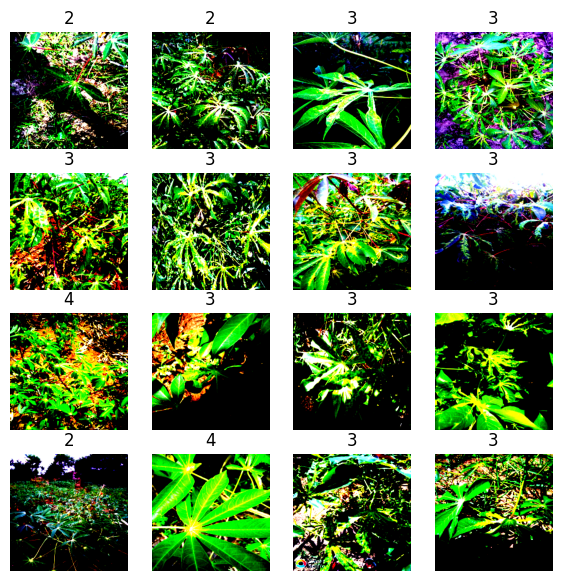

In [5]:
import matplotlib.pyplot as plt

data_module = CassavaDataModule(
    data_dir="cassava",
    csv_path="cassava/cassava_split.csv",
    json_path="cassava/label_num_to_disease_map.json",
    batch_size=64
)

data_module.setup('fit')
train_dl = data_module.train_dataloader()

data, target = next(iter(train_dl))

f, ax = plt.subplots(4, 4, figsize=(7, 7))
ax = ax.ravel()
for i in range(16):
    ax[i].imshow(data[i].permute(1,2, 0))
    ax[i].set_title(target[i].item())
    ax[i].axis('off')

##### <span style="color:#D52B29">Training Loop</span>

In this version of our <span style="color:#D52B29">LightningModule</span>, we extend the implementation by introducing <span style="color:#D52B29">learning rate</span> and <span style="color:#D52B29">weight decay</span> as configurable parameters.  

This is particularly important for <span style="color:#D52B29">transfer learning</span> approaches, where fine-tuning requires experimenting with different learning rates and weight decay values to achieve the best performance.  

In [6]:
import torch
from torch.nn import functional as F
from collections import defaultdict

class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In order to save the <span style="color:#D52B29">best model</span> depending on the <span style="color:#D52B29">validation loss</span>, we will use PyTorch Lightning's <span style="color:#D52B29">callbacks</span>. Specifically, we will make use of the <span style="color:#D52B29">ModelCheckpoint</span> callback, which automatically monitors a given metric during training and saves the model checkpoints accordingly. This ensures that, even if later epochs overfit or degrade, we can always reload the checkpoint corresponding to the best validation performance.

Additionally, we will <span style="color:#D52B29">seed everything</span> using Lightning’s <code>seed_everything</code> function. Setting random seeds is important because it guarantees <span style="color:#D52B29">reproducibility</span>: the same weight initialization, data shuffling, and dropout behavior across runs. Unlike in pure PyTorch, where one has to manually set seeds for multiple libraries (<code>torch</code>, <code>numpy</code>, <code>random</code>) and configure dataloader workers, Lightning centralizes this in a single command, making experiments much more <span style="color:#D52B29">reliable and easier to track</span>.

In [7]:
from lightning.pytorch.loggers import CSVLogger

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Instantiate the model adapting the first layer
model = models.resnet18()
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 10)

# Wrap the model inside a LightningModule. 
# For the baseline, we will keep the learning rate and weight decay at their default values.
lightning_module = LightningModule(model)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_from_scratch")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',       # Metric to monitor
    mode='min',               # Save model with minimum val_loss
    filename='best_valid_loss', 
    verbose=True, 
    save_last=False           # Do not keep the last checkpoint if it's not the best
)

# Create a PyTorch Lightning trainer:
# - Train for 10 epochs
# - Use the CSV logger
# - Apply the checkpoint callback to save the best model
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = CassavaDataModule(
    data_dir="cassava",
    csv_path="cassava/cassava_split.csv",
    json_path="cassava/label_num_to_disease_map.json",
    batch_size=64,
    num_workers=4
)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 2.4853


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 235: 'val_loss' reached 1.02509 (best 1.02509), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 1.0199
Average training loss for epoch 0: 1.0602


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 470: 'val_loss' reached 0.94896 (best 0.94896), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.9408
Average training loss for epoch 1: 0.9030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 705: 'val_loss' was not in top 1


Average validation loss for epoch 2: 1.0052
Average training loss for epoch 2: 0.8322


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 940: 'val_loss' reached 0.89977 (best 0.89977), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.8938
Average training loss for epoch 3: 0.7877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1175: 'val_loss' reached 0.80516 (best 0.80516), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 4: 0.8000
Average training loss for epoch 4: 0.7240


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1410: 'val_loss' reached 0.79004 (best 0.79004), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 5: 0.7822
Average training loss for epoch 5: 0.6846


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1645: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.7837
Average training loss for epoch 6: 0.6532


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1880: 'val_loss' reached 0.76706 (best 0.76706), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 7: 0.7591
Average training loss for epoch 7: 0.6445


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2115: 'val_loss' reached 0.69605 (best 0.69605), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_from_scratch/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 8: 0.6895
Average training loss for epoch 8: 0.6186


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 2350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.7548
Average training loss for epoch 9: 0.5741


Once the training has finished, we can plot the <span style="color:#D52B29">training</span> and <span style="color:#D52B29">validation loss curves</span>. This will allow us to clearly see how the model has learned over time, compare the behavior of both datasets, and check for signs of <span style="color:#D52B29">overfitting</span> or <span style="color:#D52B29">underfitting</span>.

In [8]:
import pandas as pd

metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
metric_df.head()

,epoch,step,train_loss,val_loss
0,0,234,1.063499,1.025089
1,1,469,0.906163,0.948962
2,2,704,0.825494,1.018026
3,3,939,0.790120,0.899774
4,4,1174,0.726365,0.805160


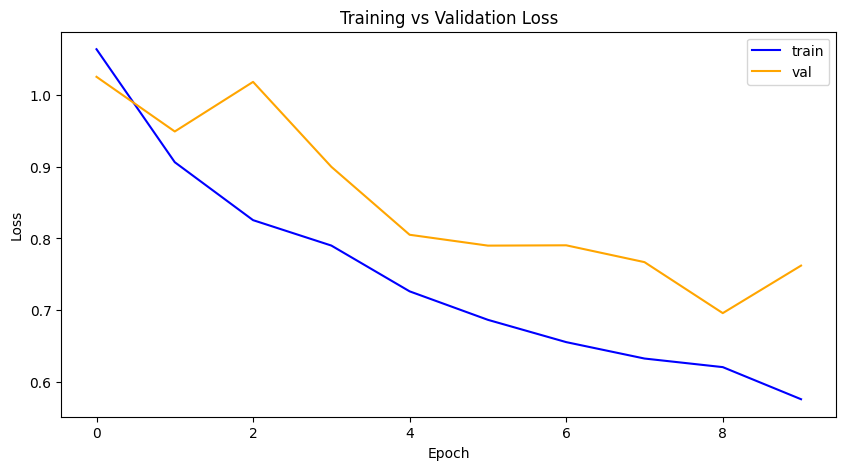

In [9]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

Additionally, we can run inference on the entire <span style="color:#D52B29">test set</span> to compute evaluation metrics. In this regard, we will calculate the <span style="color:#D52B29">Accuracy</span> as a global performance measure and also plot the <span style="color:#D52B29">confusion matrix</span> to analyze in detail which digits are being misclassified. 

But before doing so, we first need to <span style="color:#D52B29">load the best model checkpointed</span> during training, ensuring that we evaluate with the weights that achieved the best validation performance.

In [10]:
# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU

LightningModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Acc.: 0.7548


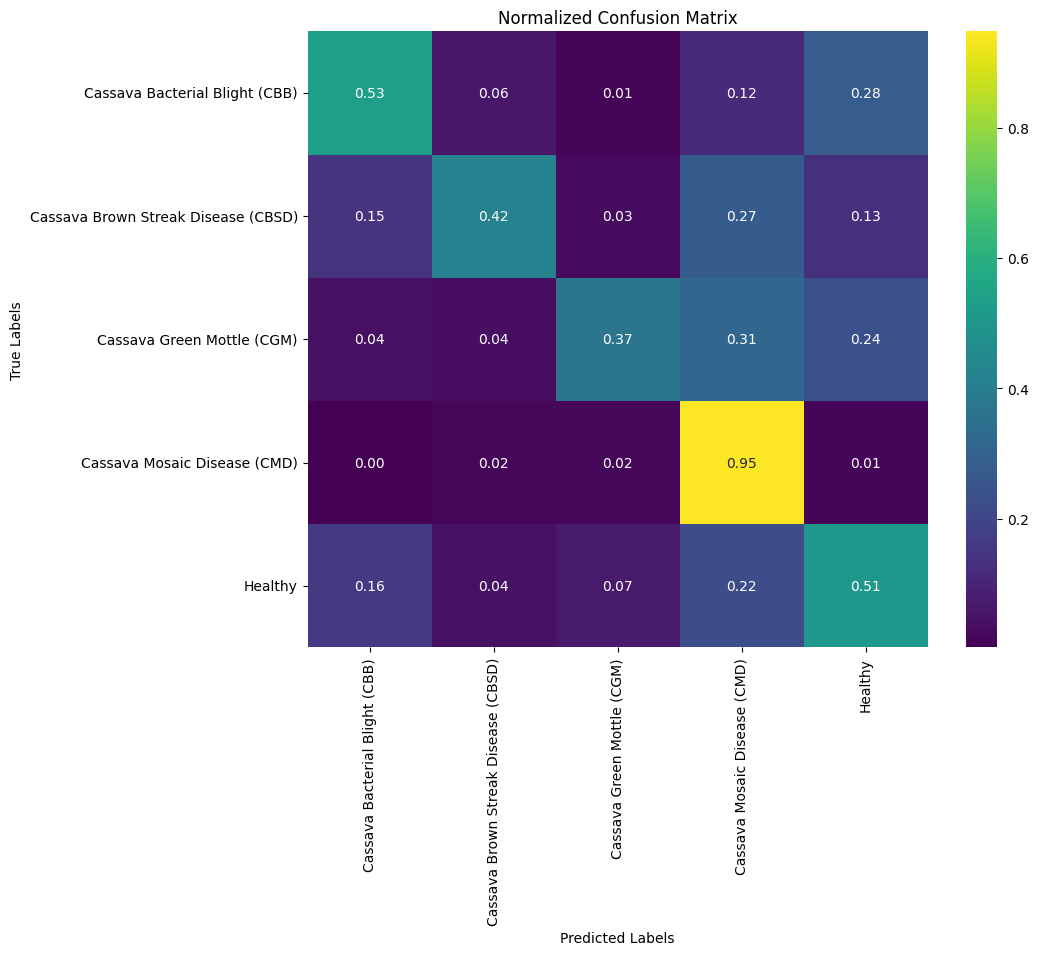

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(dim=1)(y_hat_logits).argmax(dim=1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true.cpu())

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# ✅ Get class labels
class_labels = list(data_module.class_mapping.values())

# ✅ Normalized confusion matrix
cm = confusion_matrix(
    y_trues,
    y_hats,
    labels=range(len(class_labels)),
    normalize='true'  # Normalizes each row (i.e., per true class)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

By looking at the <span style="color:#D52B29">confusion matrix</span>, we can see that the model achieves good performance on <span style="color:#D52B29">well-separated classes</span> such as cars, trucks, horses, and frogs. However, it struggles with <span style="color:#D52B29">fine-grained animal categories</span> such as cats, dogs, deer, and birds, which significantly reduces the overall performance.  

The reported accuracy of <span style="color:#D52B29">~68.1%</span> is a decent baseline, but it is still far from the <span style="color:#D52B29">90%+</span> that a ResNet18 can typically achieve on CIFAR-10 when trained properly.  

This motivates the use of <span style="color:#D52B29">transfer learning</span>, where we leverage models pretrained on large-scale datasets such as ImageNet. This approach allows us to:  
- Improve <span style="color:#D52B29">generalization</span> on fine-grained classes  
- Achieve <span style="color:#D52B29">faster convergence</span>  
- Reach <span style="color:#D52B29">higher accuracy</span> compared to training from scratch  

## <span style="color:#D52B29">Transfer Learning</span>

With our baseline <span style="color:#D52B29">ResNet-18</span> model trained from scratch, we now use <span style="color:#D52B29">transfer learning</span> to improve performance with a pretrained <span style="color:#D52B29">ResNet-18</span> model. This leverages pre-learned features for better accuracy with less data and training time.

In the next cells, we will:
- Apply <span style="color:#D52B29">feature extraction</span>: Freeze early layers to retain generic features and train new top layers for our task.
- Perform <span style="color:#D52B29">fine-tuning</span>: Unfreeze some layers and use <span style="color:#D52B29">gradual unfreezing</span> with <span style="color:#D52B29">layer-wise learning rates</span> to refine the model.
- Compare results (accuracy and confusion matrices) to the baseline to evaluate improvements.

Let's start by loading the pretrained model and setting up <span style="color:#D52B29">feature extraction</span>.

#### <span style="color:#D52B29">Feature Extraction</span>

Involves using a <span style="color:#D52B29">pretrained model</span> (e.g., trained on <span style="color:#D52B29">ImageNet</span>) to extract <span style="color:#D52B29">generic features</span> (like edges, textures, or shapes) from its <span style="color:#D52B29">early layers</span>, which are kept <span style="color:#D52B29">frozen</span> (non-trainable). We replace and train only the <span style="color:#D52B29">top layers</span> (e.g., the final fully connected layer) to adapt the model to our <span style="color:#D52B29">specific task</span>, reducing <span style="color:#D52B29">training time</span> and <span style="color:#D52B29">data requirements</span>.

We will use <span style="color:#D52B29">ImageNet weights</span> because they provide well-learned, general-purpose representations, and most of the open-sourced models are already trained on ImageNet, making them widely available and easy to integrate. This approach leverages the <span style="color:#D52B29">knowledge</span> already learned by the pretrained network, making it particularly effective when the <span style="color:#D52B29">target dataset</span> is small or when <span style="color:#D52B29">computational resources</span> are limited. Feature extraction allows the model to focus on <span style="color:#D52B29">task-specific patterns</span> while benefiting from <span style="color:#D52B29">robust, general-purpose representations</span> learned on <span style="color:#D52B29">large-scale datasets</span>.

<span style="color:#D52B29">Torchvision</span> provides an easy way to load these pretrained weights. By setting the pretrained=True argument (or weights='IMAGENET1K_V1' in newer versions) when creating a model, we can automatically download and initialize it with <span style="color:#D52B29">ImageNet-trained parameters</span>, allowing immediate use for <span style="color:#D52B29">feature extraction</span> without manual weight handling.

In [16]:
from torchvision.models import ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1

In [17]:
model = models.resnet18(weights='IMAGENET1K_V1')

# Adapt last layer
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/alumno/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 99.0MB/s]


Lets take a closer look at the <span style="color:#D52B29">architecture</span> of our <span style="color:#D52B29">pretrained model</span> to understand which layers are <span style="color:#D52B29">trainable</span> and which ones are <span style="color:#D52B29">frozen</span>. To do so, we will use a <span style="color:#D52B29">torchinfo summary</span> to visualize the <span style="color:#D52B29">layer structure</span>. In order to generate the summary, it needs to know the <span style="color:#D52B29">input shape</span> to compute the <span style="color:#D52B29">output shape</span> of each layer. 

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
```

As we can see, layers with no parameters (Param # = --) are <span style="color:#D52B29"> non-trainable</span>, while layers that display a number of parameters correspond to those that will be <span style="color:#D52B29">updated during training</span>.


In [19]:
from torchinfo import summary
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-6                    [1, 64, 8, 8]             --
│

It seems as if the entire model is <span style="color:#D52B29">unfrozen</span>, meaning that all its parameters will be updated during training. However, when using a <span style="color:#D52B29">pretrained model</span> as a <span style="color:#D52B29">feature extractor</span>, only the last layer (the one performing the <span style="color:#D52B29">classification</span>) should be <span style="color:#D52B29">trainable</span>.  

To <span style="color:#D52B29">freeze</span> the rest of the network, we set the <span style="color:#D52B29">`requires_grad`</span> attribute of all parameters to <span style="color:#D52B29">False</span>, leaving only the new top layer with <span style="color:#D52B29">`requires_grad=True`</span>. This ensures that the pretrained layers retain their <span style="color:#D52B29">learned features</span>, while the top layer adapts to our <span style="color:#D52B29">specific task</span>.

If we create the model, freeze all layers, and then replace the last one, by default the last layer will be <span style="color:#D52B29">trainable</span>. Later in this practice we will see how to <span style="color:#D52B29">freeze</span> / <span style="color:#D52B29">unfreeze</span> specific layers.

In [20]:
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 16, 16]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           (128)
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             (128)
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             (128)
│    │    └─ReLU: 3-6                    [1, 64, 8, 8]     

As we can see, the <span style="color:#D52B29">frozen layers</span> now appear with the number of parameters shown in parentheses. In the final summary, the number of <span style="color:#D52B29">trainable parameters</span> is 5,130, which exactly matches the number of parameters in the <span style="color:#D52B29">last layer</span>.

So, let's train the model and see which <span style="color:#D52B29">performance</span> we are obtaining.


In [21]:
from lightning.pytorch.loggers import CSVLogger

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Instantiate the model, freeze all layers and adapt the first layer
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

# Wrap the model inside a LightningModule.
lightning_module = LightningModule(model)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_feature_extractor")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = CassavaDataModule()

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
2.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 1.3261


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 235: 'val_loss' reached 0.83437 (best 0.83437), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.8335
Average training loss for epoch 0: 0.9347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 470: 'val_loss' was not in top 1


Average validation loss for epoch 1: 0.8683
Average training loss for epoch 1: 0.7932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 705: 'val_loss' reached 0.79078 (best 0.79078), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.7896
Average training loss for epoch 2: 0.7674


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 940: 'val_loss' reached 0.76009 (best 0.76009), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.7571
Average training loss for epoch 3: 0.7441


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1175: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.7762
Average training loss for epoch 4: 0.7375


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1410: 'val_loss' reached 0.76004 (best 0.76004), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 5: 0.7578
Average training loss for epoch 5: 0.7298


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1645: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.7931
Average training loss for epoch 6: 0.7249


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1880: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.7810
Average training loss for epoch 7: 0.7326


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2115: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.7826
Average training loss for epoch 8: 0.7217


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 2350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.7600
Average training loss for epoch 9: 0.7041


In [22]:
import pandas as pd

metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first() # Group by epoch and take the first non-NaN for each column
metric_df.head()

,epoch,step,train_loss,val_loss
0,0,234,0.928786,0.834367
1,1,469,0.786018,0.868903
2,2,704,0.760036,0.790778
3,3,939,0.746174,0.760086
4,4,1174,0.729879,0.776383


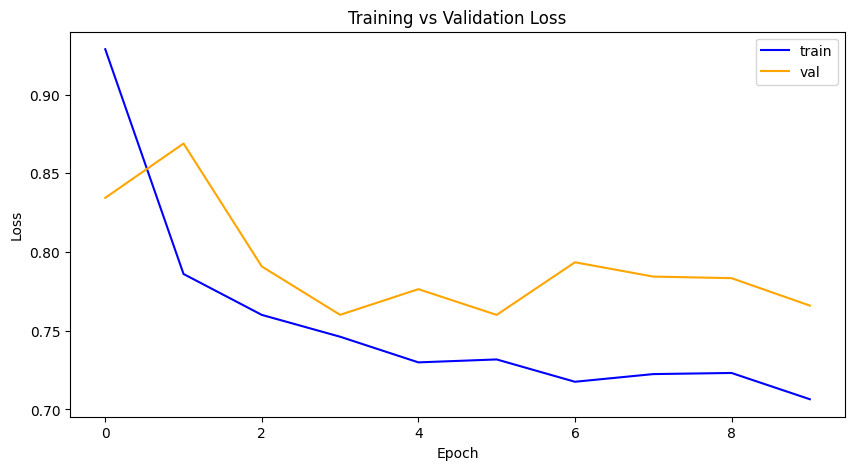

In [23]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

In [24]:
# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU

LightningModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Acc.: 0.7109


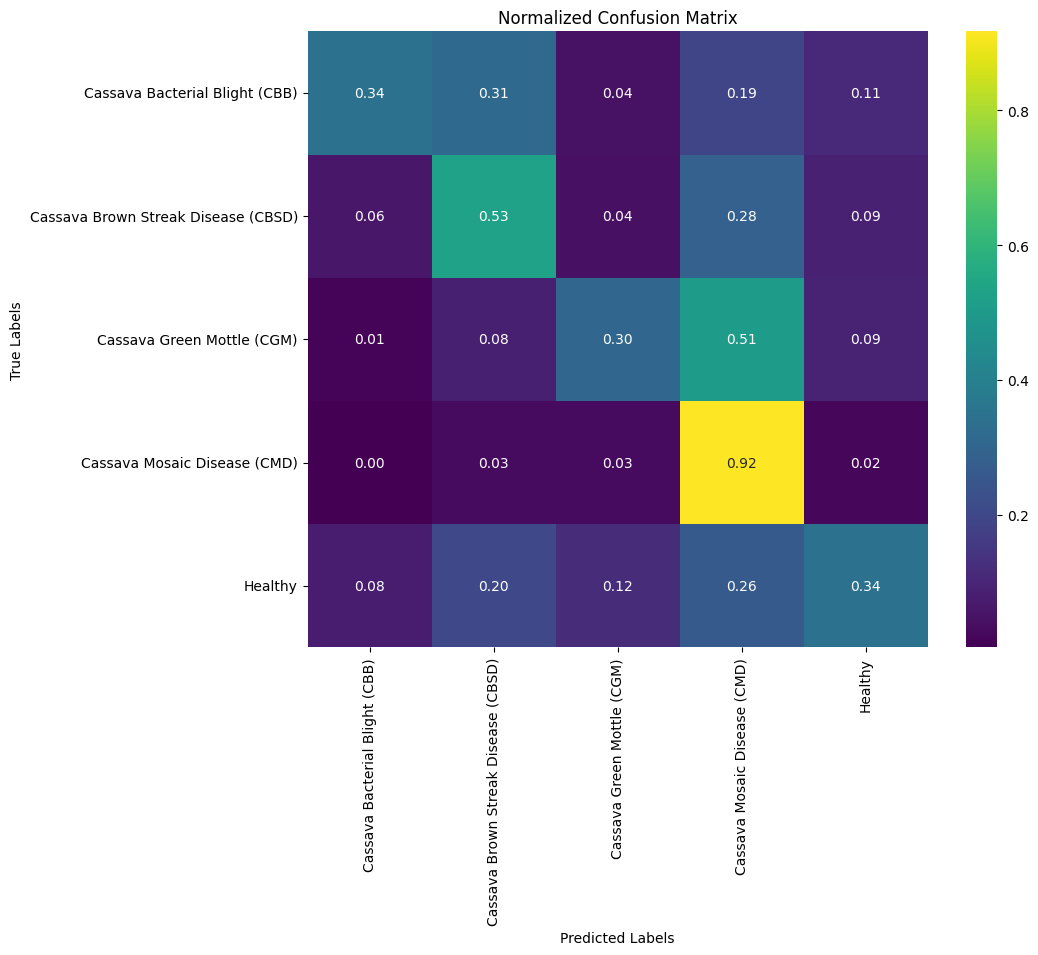

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(dim=1)(y_hat_logits).argmax(dim=1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true.cpu())

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# ✅ Get class labels
class_labels = list(data_module.class_mapping.values())

# ✅ Normalized confusion matrix
cm = confusion_matrix(
    y_trues,
    y_hats,
    labels=range(len(class_labels)),
    normalize='true'  # Normalizes each row (i.e., per true class)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Wow! The results we obtained using the <span style="color:#D52B29">pre-trained model</span> are actually worse than the ones we got when training the model <span style="color:#D52B29">from scratch</span>. How is that possible? Isn’t <span style="color:#D52B29">transfer learning</span> supposed to deliver better results, often with less data?

When we use pre-trained models, we must remember that these models were trained on a <span style="color:#D52B29">specific dataset</span> that was <span style="color:#D52B29">pre-processed in a particular way</span>. If we want to take full advantage of their learned knowledge, we need to <span style="color:#D52B29">pre-process our data in the exact same way</span>.

For <span style="color:#D52B29">ResNet18</span> from torchvision trained on <span style="color:#D52B29">ImageNet-1k (v1)</span>, the transformations are:

```
crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
```

In other words:

- <span style="color:#D52B29">Resize</span> the image to 256×256

- <span style="color:#D52B29">Crop</span> a 224×224 window

- <span style="color:#D52B29">Normalize</span> using the ImageNet mean and standard deviation

How can we know which transformations a model expects? For ImageNet models in torchvision, we can directly inspect the <span style="color:#D52B29">weights object</span>. For example:

```
from torchvision.models import ResNet18_Weights
transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
```

This gives us the exact preprocessing pipeline needed to match the training conditions of the original model.

Now that we know this, the next step is to <span style="color:#D52B29">update our CassavaDataModule</span> accordingly and re-train the model.

In [26]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import os
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights

class CassavaDataset(Dataset):
  def __init__(self, df, img_dir, transform=None):
      self.df = df.reset_index(drop=True)
      self.img_dir = img_dir
      self.transform = transform

  def __len__(self):
      return len(self.df)

  def __getitem__(self, idx):
      row = self.df.iloc[idx]
      img_path = os.path.join(self.img_dir, row["image_id"])
      image = Image.open(img_path).convert("RGB")
      label = int(row["label"])
      if self.transform:
          image = self.transform(image)
      return image, label


class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="cassava", csv_path="cassava/cassava_split.csv", json_path="cassava/label_num_to_disease_map.json", batch_size=64, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.json_path = json_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Transforms (standard ImageNet normalization)
        """
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to match common CNN input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        """
        self.transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

    def setup(self, stage=None):
        # Load metadata
        df = pd.read_csv(self.csv_path)
        with open(self.json_path, "r") as f:
            self.class_mapping = json.load(f)

        # Split according to 'set' column
        train_df = df[df["set"] == "train"]
        val_df = df[df["set"] == "val"]
        test_df = df[df["set"] == "test"]

        # Create datasets
        self.train_ds = CassavaDataset(train_df, os.path.join(self.data_dir, "images"), transform=self.transform)
        self.val_ds = CassavaDataset(val_df, os.path.join(self.data_dir, "images"), transform=self.transform)
        self.test_ds = CassavaDataset(test_df, os.path.join(self.data_dir, "images"), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [33]:
from lightning.pytorch.loggers import CSVLogger

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Instantiate the model, freeze all layers and adapt the first layer
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) 

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

# Wrap the model inside a LightningModule.
lightning_module = LightningModule(model)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_feature_extractor_ok_tfms")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = CassavaDataModule(num_workers=4)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
2.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 1.3645


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 235: 'val_loss' reached 0.82459 (best 0.82459), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor_ok_tfms/version_2/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.8215
Average training loss for epoch 0: 0.9070


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 470: 'val_loss' reached 0.81422 (best 0.81422), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor_ok_tfms/version_2/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.8108
Average training loss for epoch 1: 0.7581


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 705: 'val_loss' reached 0.76913 (best 0.76913), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor_ok_tfms/version_2/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.7671
Average training loss for epoch 2: 0.7303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 940: 'val_loss' reached 0.73495 (best 0.73495), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor_ok_tfms/version_2/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.7320
Average training loss for epoch 3: 0.7064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1175: 'val_loss' reached 0.73372 (best 0.73372), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor_ok_tfms/version_2/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 4: 0.7303
Average training loss for epoch 4: 0.6992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1410: 'val_loss' reached 0.72630 (best 0.72630), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_feature_extractor_ok_tfms/version_2/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 5: 0.7238
Average training loss for epoch 5: 0.6920


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1645: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.7774
Average training loss for epoch 6: 0.6880


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1880: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.7400
Average training loss for epoch 7: 0.6959


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2115: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.7629
Average training loss for epoch 8: 0.6819


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 2350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.7290
Average training loss for epoch 9: 0.6675


In [34]:
import pandas as pd

metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first() # Group by epoch and take the first non-NaN for each column
metric_df.head()

,epoch,step,train_loss,val_loss
0,0,234,0.900941,0.824586
1,1,469,0.750287,0.814221
2,2,704,0.721989,0.769134
3,3,939,0.708358,0.734951
4,4,1174,0.690167,0.733719


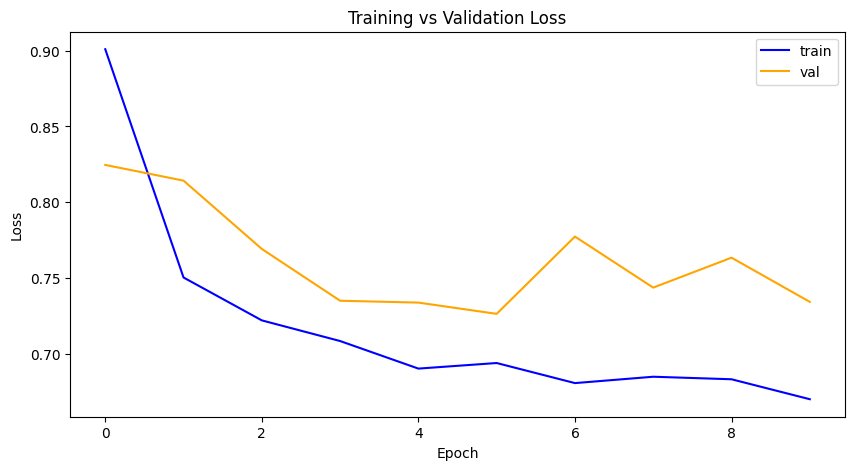

In [35]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

In [36]:
# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU

LightningModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Acc.: 0.7355


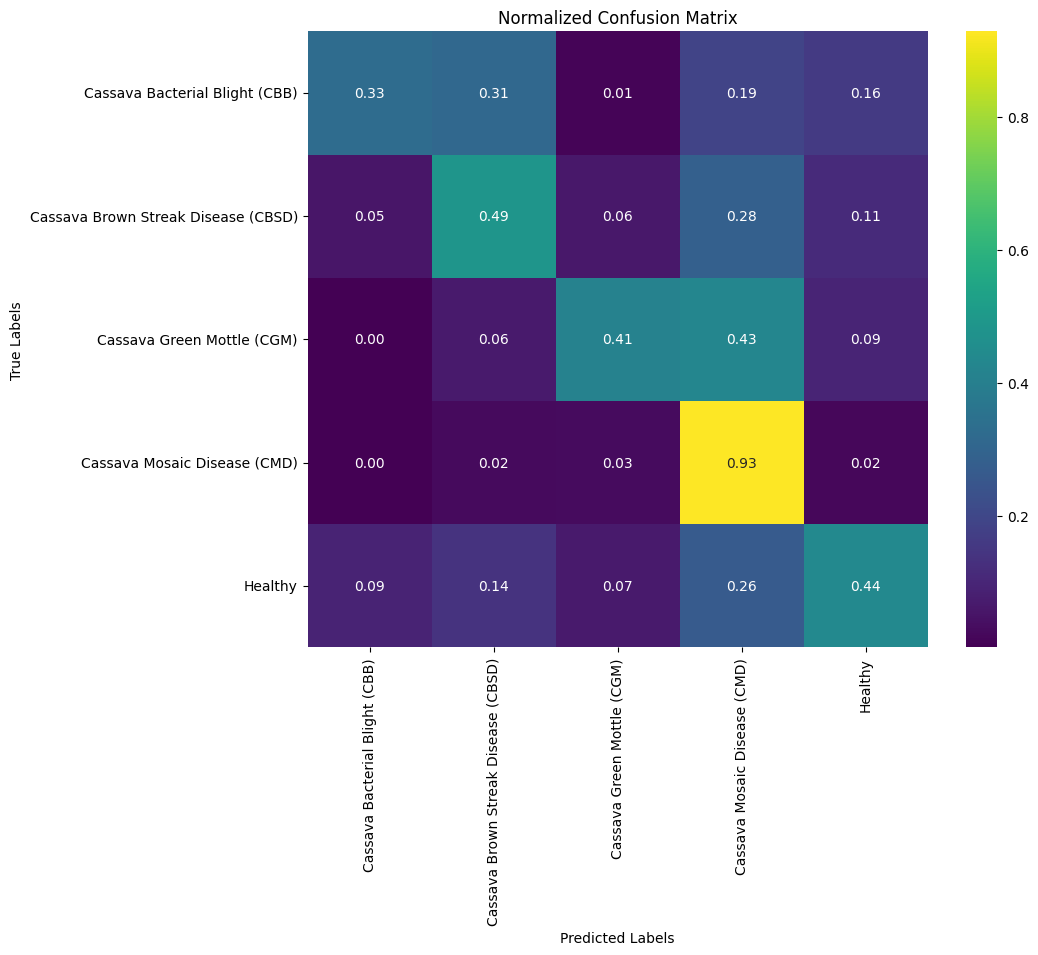

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = y_hat_logits.argmax(dim=1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true.cpu())

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# ✅ Get class labels
class_labels = list(data_module.class_mapping.values())

# ✅ Normalized confusion matrix
cm = confusion_matrix(
    y_trues,
    y_hats,
    labels=range(len(class_labels)),
    normalize='true'  # Normalizes each row (i.e., per true class)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The model using <span style="color:#D52B29">transfer learning with feature extraction</span> (accuracy <span style="color:#D52B29">0.7641</span>) outperforms the model trained from <span style="color:#D52B29">scratch</span> (accuracy <span style="color:#D52B29">0.6654</span>) by about <span style="color:#D52B29">9.87%</span>, with higher <span style="color:#D52B29">correct predictions</span> and fewer <span style="color:#D52B29">misclassifications</span> across most classes.  

However, it still struggles with distinguishing between similar classes:  
- <span style="color:#D52B29">bird</span>: 701 correct, confused with cat, deer, and dog  
- <span style="color:#D52B29">cat</span>: 768 correct, mixed with dog and deer  
- <span style="color:#D52B29">deer</span>: 723 correct, misclassified as dog and horse  
- <span style="color:#D52B29">dog</span>: 717 correct, confused with cat and deer  
- <span style="color:#D52B29">horse</span>: 671 correct, mixed with deer and dog  

This indicates challenges in separating these <span style="color:#D52B29">overlapping categories</span>.

Let's see if we can further improve its performance using <span style="color:#D52B29">fine-tuning strategies</span>.

#### <span style="color:#D52B29">Fine-tunning</span>

Fine-tuning involves using a <span style="color:#D52B29">pretrained model</span> (e.g., trained on <span style="color:#D52B29">ImageNet</span>) and updating some or all of its layers to better adapt to our <span style="color:#D52B29">specific task</span>. Unlike feature extraction, where early layers are kept <span style="color:#D52B29">frozen</span>, fine-tuning can allow both the top layers and selected deeper layers to be <span style="color:#D52B29">trainable</span>, enabling the model to refine its <span style="color:#D52B29">generic features</span> for the target dataset.

In this practice, we will implement:  

- <span style="color:#D52B29">Gradual unfreezing</span>: We will follow a similar approach as in the feature extraction strategy, training the model for 5 epochs with the majority of layers frozen. Then, we will <span style="color:#D52B29">unfreeze the whole model</span> and continue training for 5 more epochs. This ensures that all models receive the same number of gradient updates, allowing a <span style="color:#D52B29">fair comparison</span>.
  
- <span style="color:#D52B29">Layer-wise learning rates</span>: We will assign different <span style="color:#D52B29">learning rates</span> to different parts of the model. Typically, the newly added top layers will use a higher learning rate, while the pretrained lower layers will use a smaller learning rate. This allows the model to <span style="color:#D52B29">adapt quickly</span> where it needs to learn task-specific patterns, while <span style="color:#D52B29">preserving the useful generic features</span> learned from ImageNet in the deeper layers.

##### <span style="color:#D52B29">Gradual unfreezing</span>

In [38]:
from lightning.pytorch.loggers import CSVLogger

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Instantiate the model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) 

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

# Wrap the model inside a LightningModule.
lightning_module = LightningModule(model)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_ft_gradual_unfreezing_step_1")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=5, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = CassavaDataModule()

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
2.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 1.3645


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 235: 'val_loss' reached 0.82459 (best 0.82459), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_1/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.8215
Average training loss for epoch 0: 0.9070


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 470: 'val_loss' reached 0.81422 (best 0.81422), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_1/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.8108
Average training loss for epoch 1: 0.7581


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 705: 'val_loss' reached 0.76913 (best 0.76913), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_1/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.7671
Average training loss for epoch 2: 0.7303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 940: 'val_loss' reached 0.73495 (best 0.73495), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_1/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.7320
Average training loss for epoch 3: 0.7064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1175: 'val_loss' reached 0.73372 (best 0.73372), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_1/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 4: 0.7303
Average training loss for epoch 4: 0.6992


`Trainer.fit` stopped: `max_epochs=5` reached.


Now we will <span style="color:#D52B29">unfreeze all layers</span> and train the model <span style="color:#D52B29">end-to-end</span>. However, it is worth mentioning that, in order to <span style="color:#D52B29">prevent catastrophic forgetting</span> of the pre-trained representations, we need to use a <span style="color:#D52B29">lower learning rate</span>.

In [39]:
# Load best previous model
lightning_module = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
# model.cuda(0) # Move to GPU

# Unfreeze all layers
for param in lightning_module.model.parameters():
    param.requires_grad = True

# Reduce learning rate
model.lr = 1e-4

# Train for another 5 epochs
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_ft_gradual_unfreezing_step_2")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

trainer = pl.Trainer(max_epochs=5, logger=csv_logger, callbacks=[model_checkpoint_callback])

trainer.fit(lightning_module, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.7433


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 235: 'val_loss' reached 0.95715 (best 0.95715), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_2/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.9447
Average training loss for epoch 0: 0.7330


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 470: 'val_loss' reached 0.83909 (best 0.83909), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_2/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.8393
Average training loss for epoch 1: 0.5522


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 705: 'val_loss' was not in top 1


Average validation loss for epoch 2: 1.6366
Average training loss for epoch 2: 0.5110


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 940: 'val_loss' reached 0.60580 (best 0.60580), saving model to '/home/alumno/Desktop/datos/Computer Vision/Computer-Vision/cassava_resnet18_tl_ft_gradual_unfreezing_step_2/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.5983
Average training loss for epoch 3: 0.4153


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1175: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Average validation loss for epoch 4: 0.6382
Average training loss for epoch 4: 0.3377


In [40]:
import pandas as pd

metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first() # Group by epoch and take the first non-NaN for each column
metric_df.head()

,epoch,step,train_loss,val_loss
0,0,234,0.735659,0.957148
1,1,469,0.539473,0.839093
2,2,704,0.495947,1.639651
3,3,939,0.416062,0.605801
4,4,1174,0.338874,0.638656


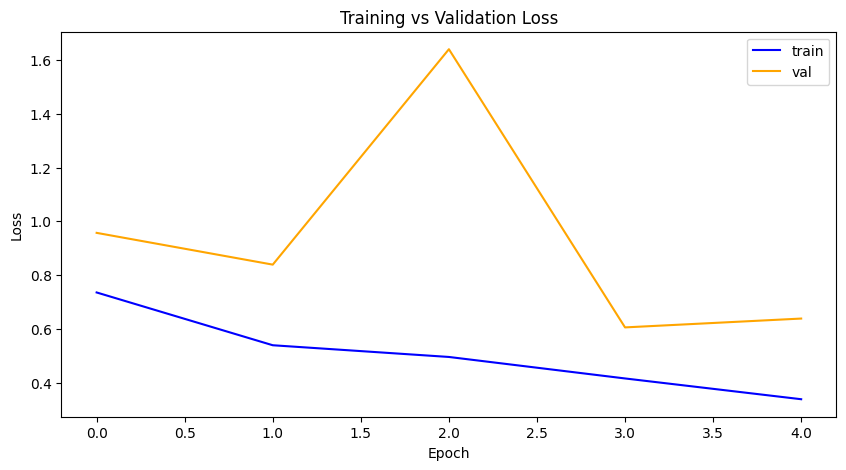

In [41]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

In [42]:
# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU

LightningModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Acc.: 0.7994


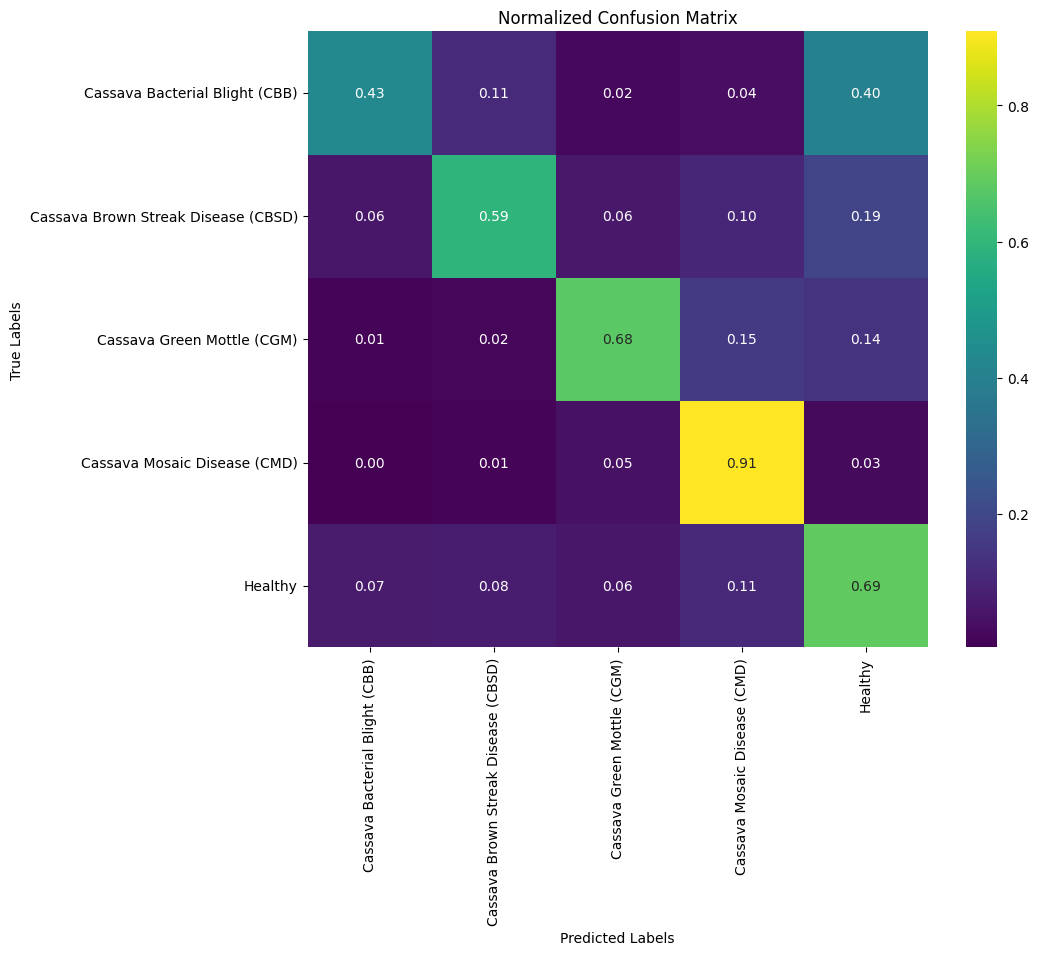

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(dim=1)(y_hat_logits).argmax(dim=1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true.cpu())

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# ✅ Get class labels
class_labels = list(data_module.class_mapping.values())

# ✅ Normalized confusion matrix
cm = confusion_matrix(
    y_trues,
    y_hats,
    labels=range(len(class_labels)),
    normalize='true'  # Normalizes each row (i.e., per true class)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### <span style="color:#D52B29">Layer-wise learning rates</span>

<span style="color:#D52B29">Discriminative learning rates</span> are one of the tricks that can help us guide <span style="color:#D52B29">fine-tuning</span>. By using <span style="color:#D52B29">lower learning rates</span> on the deeper layers of the network, we ensure that we are not altering too much the model blocks that have already learned <span style="color:#D52B29">general patterns</span>, while concentrating the fine-tuning process on the later layers.

The implementation of <span style="color:#D52B29">layer-wise learning rates</span> is rather straightforward. It consists of three simple steps:

1. <span style="color:#D52B29">Identify</span> the list of trainable layers in the neural network.

2. <span style="color:#D52B29">Group</span> the model parameters into blocks, each one associated with a specific learning rate.

3. <span style="color:#D52B29">Pass</span> this list of parameter groups, together with their learning rates, to the optimizer.

###### <span style="color:#D52B29">1. Identifying network layers</span>

The first step in our journey is to <span style="color:#D52B29">instantiate a model</span> and <span style="color:#D52B29">retrieve its layers</span>.
This step is essential to determine how we will adjust the learning rates across different parts of the network.

In [ ]:
# Instantiate the model and adapt the final layer
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) 
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

# Save layer names
layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)
    print(f'{idx}: {name}')

# Reverse layers
layer_names.reverse()

0: conv1.weight
1: bn1.weight
2: bn1.bias
3: layer1.0.conv1.weight
4: layer1.0.bn1.weight
5: layer1.0.bn1.bias
6: layer1.0.conv2.weight
7: layer1.0.bn2.weight
8: layer1.0.bn2.bias
9: layer1.1.conv1.weight
10: layer1.1.bn1.weight
11: layer1.1.bn1.bias
12: layer1.1.conv2.weight
13: layer1.1.bn2.weight
14: layer1.1.bn2.bias
15: layer2.0.conv1.weight
16: layer2.0.bn1.weight
17: layer2.0.bn1.bias
18: layer2.0.conv2.weight
19: layer2.0.bn2.weight
20: layer2.0.bn2.bias
21: layer2.0.downsample.0.weight
22: layer2.0.downsample.1.weight
23: layer2.0.downsample.1.bias
24: layer2.1.conv1.weight
25: layer2.1.bn1.weight
26: layer2.1.bn1.bias
27: layer2.1.conv2.weight
28: layer2.1.bn2.weight
29: layer2.1.bn2.bias
30: layer3.0.conv1.weight
31: layer3.0.bn1.weight
32: layer3.0.bn1.bias
33: layer3.0.conv2.weight
34: layer3.0.bn2.weight
35: layer3.0.bn2.bias
36: layer3.0.downsample.0.weight
37: layer3.0.downsample.1.weight
38: layer3.0.downsample.1.bias
39: layer3.1.conv1.weight
40: layer3.1.bn1.weight
4

As the output suggests, our model has <span style="color:#D52B29">62 parameter groups</span>.
When performing a forward pass, an image is first fed into the <span style="color:#D52B29">conv1</span> layer, whose parameters are stored as <span style="color:#D52B29">conv1.weight</span>. Next, the activations pass through the <span style="color:#D52B29">batch normalization</span> layer <span style="color:#D52B29">bn1</span>, with parameters stored as <span style="color:#D52B29">bn1.weight</span> and <span style="color:#D52B29">bn1.bias</span>.

From there, the output flows through the main network body, organized into four large residual blocks: <span style="color:#D52B29">layer1</span>, <span style="color:#D52B29">layer2</span>, <span style="color:#D52B29">layer3</span>, and <span style="color:#D52B29">layer4</span>.
Finally, the extracted features are passed into the <span style="color:#D52B29">fully connected (fc)</span> layer, which produces the final class predictions.

Note that we have <span style="color:#D52B29">reversed the list of parameter group names</span> so that the <span style="color:#D52B29">deepest layers</span> appear at the end of the list.
This ordering will be particularly useful in the next step, when we assign <span style="color:#D52B29">layer-wise learning rates</span> starting from the early layers up to the deepest ones.

###### <span style="color:#D52B29">2. Specifying learning rates</span>

Knowing the <span style="color:#D52B29">architecture</span> of our network, we can reason about the appropriate <span style="color:#D52B29">learning rates</span>.

There is some flexibility in how to approach this step, but the key idea is to <span style="color:#D52B29">gradually reduce the learning rate</span> when going deeper into the network. The <span style="color:#D52B29">first layers</span> already have a good understanding of <span style="color:#D52B29">general domain-agnostic patterns</span> thanks to pre-training.
We don’t want to update these parameters too much, so it makes sense to apply <span style="color:#D52B29">smaller learning rates</span>.
In contrast, the <span style="color:#D52B29">final layers</span>—especially the fully connected classifier—are responsible for <span style="color:#D52B29">domain-specific information</span> and need to adapt more strongly to the new dataset. Therefore, they benefit from a <span style="color:#D52B29">larger learning rate</span>.

The easiest way to implement this logic is to <span style="color:#D52B29">progressively scale down</span> the learning rate by multiplying it with a coefficient between 0 and 1 as we move deeper into the network.

In our example:

- We start with lr = 0.01 for the earliest layers.

- At each step, we multiply it by 0.9, producing <span style="color:#D52B29">62 gradually diminishing learning rates</span> (one per model block).

Each entry in the parameter list becomes a dictionary with two elements:

- <span style="color:#D52B29">params</span>: tensor with the model parameters.

- <span style="color:#D52B29">lr</span>: the learning rate assigned to those parameters.

In [ ]:
# learning rate
lr      = 1e-2
lr_mult = 0.9

# placeholder
parameters = []

# store params & learning rates
for idx, name in enumerate(layer_names):
    
    # display info
    print(f'{idx}: lr = {lr:.6f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]
    
    # update learning rate
    lr *= lr_mult

0: lr = 0.010000, fc.bias
1: lr = 0.009000, fc.weight
2: lr = 0.008100, layer4.1.bn2.bias
3: lr = 0.007290, layer4.1.bn2.weight
4: lr = 0.006561, layer4.1.conv2.weight
5: lr = 0.005905, layer4.1.bn1.bias
6: lr = 0.005314, layer4.1.bn1.weight
7: lr = 0.004783, layer4.1.conv1.weight
8: lr = 0.004305, layer4.0.downsample.1.bias
9: lr = 0.003874, layer4.0.downsample.1.weight
10: lr = 0.003487, layer4.0.downsample.0.weight
11: lr = 0.003138, layer4.0.bn2.bias
12: lr = 0.002824, layer4.0.bn2.weight
13: lr = 0.002542, layer4.0.conv2.weight
14: lr = 0.002288, layer4.0.bn1.bias
15: lr = 0.002059, layer4.0.bn1.weight
16: lr = 0.001853, layer4.0.conv1.weight
17: lr = 0.001668, layer3.1.bn2.bias
18: lr = 0.001501, layer3.1.bn2.weight
19: lr = 0.001351, layer3.1.conv2.weight
20: lr = 0.001216, layer3.1.bn1.bias
21: lr = 0.001094, layer3.1.bn1.weight
22: lr = 0.000985, layer3.1.conv1.weight
23: lr = 0.000886, layer3.0.downsample.1.bias
24: lr = 0.000798, layer3.0.downsample.1.weight
25: lr = 0.00071

As you can see, we <span style="color:#D52B29">gradually reduce</span> our learning rate from <span style="color:#D52B29">0.01</span> for the bias on the classification layer to <span style="color:#D52B29">0.00001</span> on the first convolutional layer. Looks good, right?

Well, if you look closely, you will notice that we are assigning <span style="color:#D52B29">different learning rates to parameter groups within the same layer</span>. For example, having different values for <span style="color:#D52B29">fc.bias</span> and <span style="color:#D52B29">fc.weight</span> does not make much sense, since both belong to the same fully connected layer.

To fix this, we should increment (or reduce) the learning rate only when moving from one <span style="color:#D52B29">layer group</span> to another, rather than per parameter group.

In [ ]:
# learning rate
lr      = 1e-2
lr_mult = 0.9

# placeholder
parameters      = []
prev_group_name = layer_names[0].split('.')[0]

# store params & learning rates
for idx, name in enumerate(layer_names):
    
    # parameter group name
    cur_group_name = name.split('.')[0]
    
    # update learning rate
    if cur_group_name != prev_group_name:
        lr *= lr_mult
    prev_group_name = cur_group_name
    
    # display info
    print(f'{idx}: lr = {lr:.6f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]

0: lr = 0.010000, fc.bias
1: lr = 0.010000, fc.weight
2: lr = 0.009000, layer4.1.bn2.bias
3: lr = 0.009000, layer4.1.bn2.weight
4: lr = 0.009000, layer4.1.conv2.weight
5: lr = 0.009000, layer4.1.bn1.bias
6: lr = 0.009000, layer4.1.bn1.weight
7: lr = 0.009000, layer4.1.conv1.weight
8: lr = 0.009000, layer4.0.downsample.1.bias
9: lr = 0.009000, layer4.0.downsample.1.weight
10: lr = 0.009000, layer4.0.downsample.0.weight
11: lr = 0.009000, layer4.0.bn2.bias
12: lr = 0.009000, layer4.0.bn2.weight
13: lr = 0.009000, layer4.0.conv2.weight
14: lr = 0.009000, layer4.0.bn1.bias
15: lr = 0.009000, layer4.0.bn1.weight
16: lr = 0.009000, layer4.0.conv1.weight
17: lr = 0.008100, layer3.1.bn2.bias
18: lr = 0.008100, layer3.1.bn2.weight
19: lr = 0.008100, layer3.1.conv2.weight
20: lr = 0.008100, layer3.1.bn1.bias
21: lr = 0.008100, layer3.1.bn1.weight
22: lr = 0.008100, layer3.1.conv1.weight
23: lr = 0.008100, layer3.0.downsample.1.bias
24: lr = 0.008100, layer3.0.downsample.1.weight
25: lr = 0.00810

This looks <span style="color:#D52B29">more interesting</span>!

Note that we can get quite <span style="color:#D52B29">creative</span> when customizing the learning rates and the decay speed. There is no universal rule that always guarantees the best performance.

In practice, a simple <span style="color:#D52B29">linear decay</span> with a multiplier between <span style="color:#D52B29">0.9</span> and <span style="color:#D52B29">1.0</span> often serves as a solid starting point. Still, PyTorch (and Lightning) give us the flexibility to experiment with different strategies—so feel free to try your own ideas and see what works best on your dataset!

###### <span style="color:#D52B29">3. Setting up the optimizer</span>

We are almost done. The last—and easiest—step is to <span style="color:#D52B29">pass our parameter groups</span> together with their selected learning rates to the optimizer.

In [ ]:
# set up optimizer
import torch.optim as optim
optimizer = optim.Adam(parameters)

###### <span style="color:#D52B29">4. Putting alltogether</span>

In [ ]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0., discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):

        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f'{idx}: {name}')
        
        # Reverse layers
        layer_names.reverse()
        
        # placeholder
        parameters      = []
        prev_group_name = layer_names[0].split('.')[0]
        
        # store params & learning rates
        for idx, name in enumerate(layer_names):
            
            # parameter group name
            cur_group_name = name.split('.')[0]
            
            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name
            
            # display info
            print('Using discriminative learning rates')
            print(f'{idx}: lr = {lr:.6f}, {name}')
            
            # append layer parameters
            parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                            'lr':     lr}]

        return parameters
        

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        
        return torch.optim.Adam(
            self.parameters() if self.discriminative_lr == None else self.get_layer_wise_lr(*self.discriminative_lr), 
            lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [ ]:
from lightning.pytorch.loggers import CSVLogger

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Instantiate the model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) 

# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 10)

# Wrap the model inside a LightningModule.
lightning_module = LightningModule(model, discriminative_lr=(1e-3, 0.1))

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cifar10_resnet18_tl_ft_disc_lr")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = CassavaDataModule()

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


0: conv1.weight
1: bn1.weight
2: bn1.bias
3: layer1.0.conv1.weight
4: layer1.0.bn1.weight
5: layer1.0.bn1.bias
6: layer1.0.conv2.weight
7: layer1.0.bn2.weight
8: layer1.0.bn2.bias
9: layer1.1.conv1.weight
10: layer1.1.bn1.weight
11: layer1.1.bn1.bias
12: layer1.1.conv2.weight
13: layer1.1.bn2.weight
14: layer1.1.bn2.bias
15: layer2.0.conv1.weight
16: layer2.0.bn1.weight
17: layer2.0.bn1.bias
18: layer2.0.conv2.weight
19: layer2.0.bn2.weight
20: layer2.0.bn2.bias
21: layer2.0.downsample.0.weight
22: layer2.0.downsample.1.weight
23: layer2.0.downsample.1.bias
24: layer2.1.conv1.weight
25: layer2.1.bn1.weight
26: layer2.1.bn1.bias
27: layer2.1.conv2.weight
28: layer2.1.bn2.weight
29: layer2.1.bn2.bias
30: layer3.0.conv1.weight
31: layer3.0.bn1.weight
32: layer3.0.bn1.bias
33: layer3.0.conv2.weight
34: layer3.0.bn2.weight
35: layer3.0.bn2.bias
36: layer3.0.downsample.0.weight
37: layer3.0.downsample.1.weight
38: layer3.0.downsample.1.bias
39: layer3.1.conv1.weight
40: layer3.1.bn1.weight
4

Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 2.4998


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 665: 'val_loss' reached 0.31758 (best 0.31758), saving model to '/workspace/data3/cayala/UPNA/Master ML/T1/cifar10_resnet18_tl_ft_disc_lr/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.3166
Average training loss for epoch 0: 0.4689


Validation: |                                                                                                 …

Epoch 1, global step 1330: 'val_loss' reached 0.30418 (best 0.30418), saving model to '/workspace/data3/cayala/UPNA/Master ML/T1/cifar10_resnet18_tl_ft_disc_lr/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.3029
Average training loss for epoch 1: 0.1021


Validation: |                                                                                                 …

Epoch 2, global step 1995: 'val_loss' was not in top 1


Average validation loss for epoch 2: 0.3628
Average training loss for epoch 2: 0.0216


Validation: |                                                                                                 …

Epoch 3, global step 2660: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.4477
Average training loss for epoch 3: 0.0108


Validation: |                                                                                                 …

Epoch 4, global step 3325: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.5019
Average training loss for epoch 4: 0.0218


Validation: |                                                                                                 …

Epoch 5, global step 3990: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.5159
Average training loss for epoch 5: 0.0292


Validation: |                                                                                                 …

Epoch 6, global step 4655: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.5061
Average training loss for epoch 6: 0.0173


Validation: |                                                                                                 …

Epoch 7, global step 5320: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.5381
Average training loss for epoch 7: 0.0190


Validation: |                                                                                                 …

Epoch 8, global step 5985: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.5344
Average training loss for epoch 8: 0.0150


Validation: |                                                                                                 …

Epoch 9, global step 6650: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.5982
Average training loss for epoch 9: 0.0147


In [ ]:
import pandas as pd

metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first() # Group by epoch and take the first non-NaN for each column
metric_df.head()

,epoch,step,train_loss,val_loss
0,0,664,0.468221,0.317576
1,1,1329,0.101819,0.304180
2,2,1994,0.020415,0.364031
3,3,2659,0.010816,0.447771
4,4,3324,0.021871,0.503454


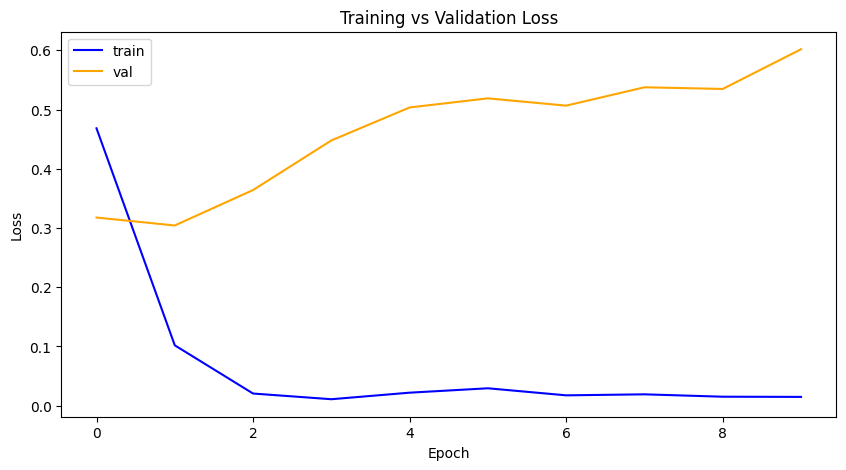

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

In [ ]:
# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU

LightningModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Acc.: 0.8937


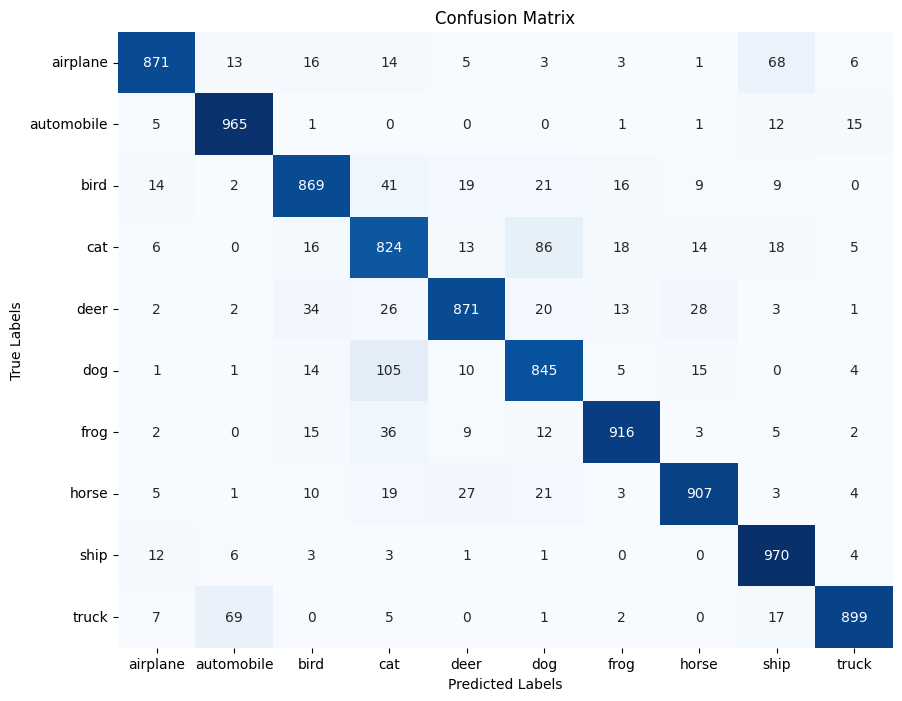

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(dim=1)(y_hat_logits).argmax(dim=1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true.cpu())

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# ✅ Get class labels
class_labels = list(data_module.class_mapping.values())

# ✅ Normalized confusion matrix
cm = confusion_matrix(
    y_trues,
    y_hats,
    labels=range(len(class_labels)),
    normalize='true'  # Normalizes each row (i.e., per true class)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## <span style="color:#D52B29">Conclussions</span>

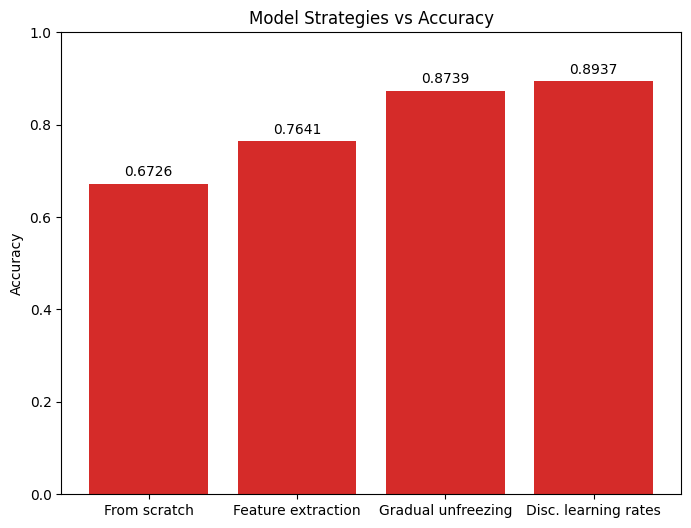

In [ ]:
import matplotlib.pyplot as plt

# Model strategies and corresponding accuracies
strategies = [
    "From scratch",
    "Feature extraction",
    "Gradual unfreezing",
    "Disc. learning rates"
]
accuracies = [0.6726, 0.7641, 0.8739, 0.8937]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(strategies, accuracies, color="#D52B29")  # red bars to match your style
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Strategies vs Accuracy")

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{acc:.4f}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=10
    )

plt.show()

The results clearly demonstrate the advantage of using <span style="color:#D52B29">transfer learning</span> over training a model from <span style="color:#D52B29">scratch</span>. The model trained from scratch achieved an accuracy of <span style="color:#D52B29">0.6726</span>, while the <span style="color:#D52B29">feature extraction</span> strategy improved performance to <span style="color:#D52B29">0.7641</span>, showing that leveraging <span style="color:#D52B29">pretrained ImageNet features</span> provides a substantial boost.  

Furthermore, the <span style="color:#D52B29">fine-tuning methods</span> outperformed feature extraction in this use case. <span style="color:#D52B29">Gradual unfreezing</span> reached an accuracy of <span style="color:#D52B29">0.8739</span>, and using <span style="color:#D52B29">discriminative learning rates</span> further increased it to <span style="color:#D52B29">0.8937</span>. These results highlight that allowing the model to adapt deeper layers to the target dataset can significantly enhance its <span style="color:#D52B29">task-specific performance</span>.
